In [ ]:
# Install seaborn if not available (only needed once)
!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA


In [ ]:
digits = load_digits()
X, y = digits.data, digits.target

print("Shape of data:", X.shape)
print("Target classes:", np.unique(y))


Shape of data: (1797, 64)
Target classes: [0 1 2 3 4 5 6 7 8 9]


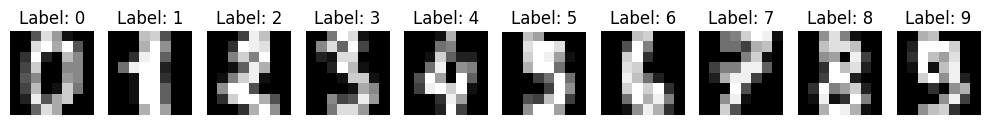

In [ ]:
# Visualize first 10 digit images
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 0.01, 0.001],
                         'svm__kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=2)

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)


Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9832970383275261


In [ ]:
y_pred = grid.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.975

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.95      0.97      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      1.00      0.99        36
           7       0.92      0.97      0.95        36
           8       1.00      0.91      0.96        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



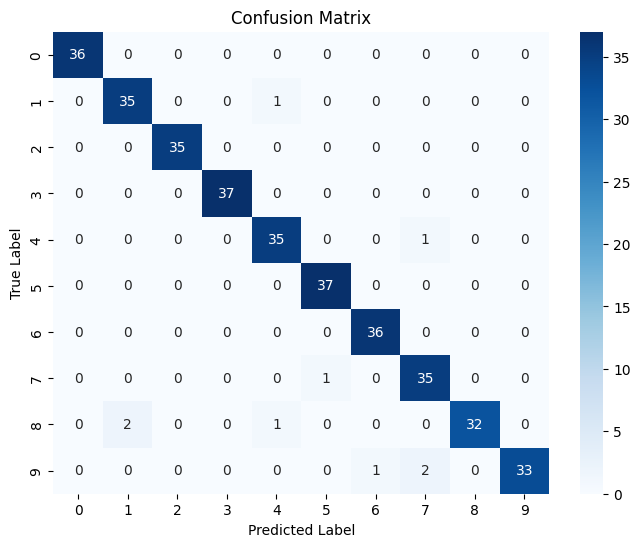

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


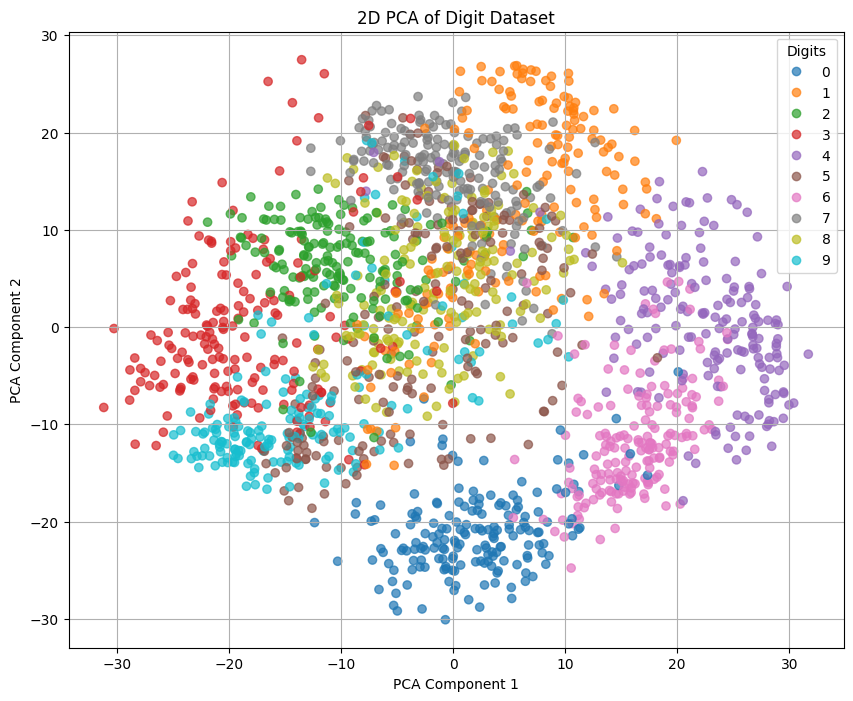

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of Digit Dataset")
plt.grid(True)
plt.show()


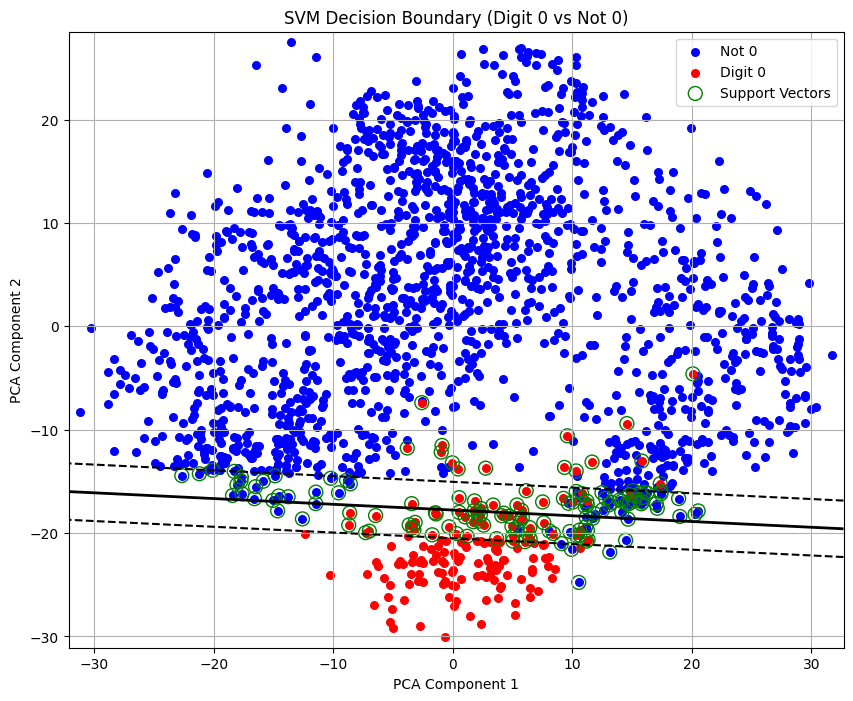

In [ ]:
# Convert to binary classification: digit '0' vs. not '0'
y_binary = (digits.target == 0).astype(int)  # 1 for '0', 0 for others

# Apply PCA to reduce to 2D
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(digits.data)

# Fit SVM with linear kernel for binary classification
svm_binary = SVC(kernel='linear', C=1)
svm_binary.fit(X_2d, y_binary)

# Create meshgrid
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Compute decision function for each point in mesh
Z = svm_binary.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary, margins, and support vectors
plt.figure(figsize=(10, 8))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')          # decision boundary
plt.contour(xx, yy, Z, levels=[-1, 1], linestyles='--', colors='black')   # margins

# Plot data points
plt.scatter(X_2d[y_binary == 0][:, 0], X_2d[y_binary == 0][:, 1], c='blue', label='Not 0', s=30)
plt.scatter(X_2d[y_binary == 1][:, 0], X_2d[y_binary == 1][:, 1], c='red', label='Digit 0', s=30)

# Support vectors
plt.scatter(svm_binary.support_vectors_[:, 0], svm_binary.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='green', label='Support Vectors')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SVM Decision Boundary (Digit 0 vs Not 0)")
plt.legend()
plt.grid(True)
plt.show()
